# Определение перспективного тарифа для телеком-компании

## Описание проекта

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо провести анализ клиентов на небольшой выборке и сформулировать выводы - какой тариф лучше.

### Описание тарифов

#### Тариф «Смарт»
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.


## 1. Первичное изучение данных и предобработка

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

sns.set(style = 'darkgrid')

In [3]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv', index_col=[0])
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets//tariffs.csv')
df_users = pd.read_csv('/datasets//users.csv')

In [4]:
# функция для построения гистограммы
def hist_plot(data, column):
    data.plot(y=column, kind = 'hist', figsize=(15,8), grid=True, bins = 50)

#### Данные о звонках

Таблица df_calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок


In [5]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
# приведём столбец call_date к формату времени.
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d', errors='coerce')

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

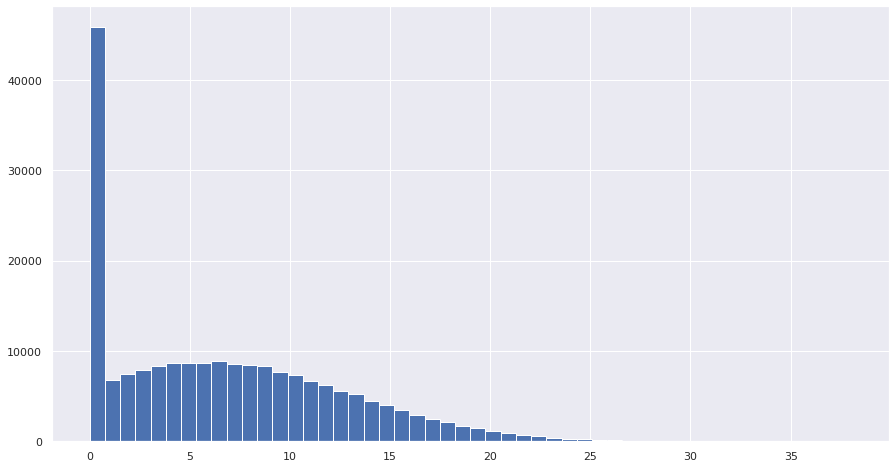

In [7]:
# в столбце 'duration' много звонков с длительностью 0.
df_calls['duration'].hist(bins = 50, figsize=(15,8))
df_calls.query('duration == 0').count()

Скорее всего, это звонки, которые так и не были осуществлены (пропущенные, сброшенные и тд.)
Таких звонков почти 40000, т.е. около 20% от данных.

Так как мы изучаем тарифы, нас в первую очередь будут интересовать услуги, которые по данным тарифам были оказаны. В случае со звонками нулевой продолжительности, никакой услуги оказано не было, эти данные в рассчёты по тарифам не попадут. 
Поэтому мы отбросим строки с нулевой длительностью звонка.

Также, по условиям оператора, округление значений минут для рассчётов осуществляется вверх. Поэтому также округлим наши данные и приведём к целочисленному формату.

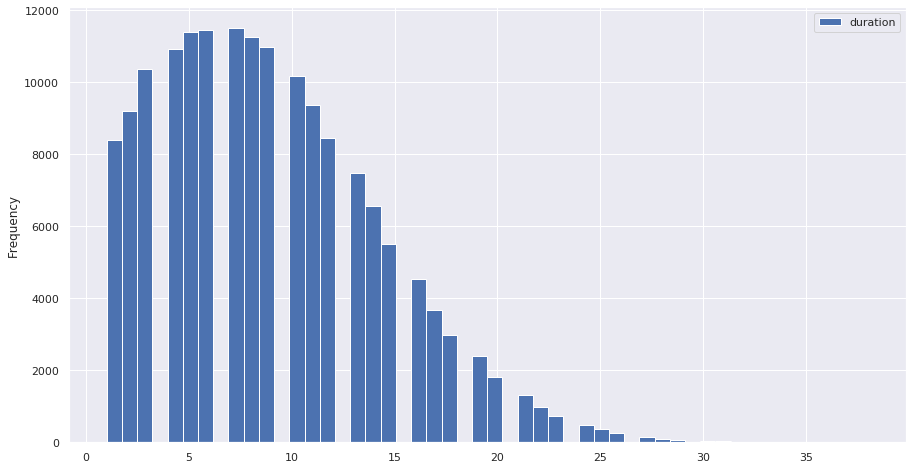

In [8]:
# Возьмём только ненулевые звонки
df_calls = df_calls.query('duration != 0')

# округлим значения "вверх" и посмотрим гистограмму
df_calls['duration'] = df_calls['duration'].apply(np.ceil).astype('int')
hist_plot(df_calls, 'duration')

Большая часть звонков весьма короткие - от 1 до 10 минут, но есть данные и о получасовых переговорах.
Данные выглядит логично, форматы правильные.

#### Данные об использовании интернет

Таблица df_internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя


In [9]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


С данными по использованному интернет похожая ситуация, как и со звонками - почти 20000 нулевых значений.
Предположим, что нулевые значения получились, когда клиент интернет активировал, но трафика получено не было -> услуга оператора по тарифу оказана не была -> отброс этих данных не повлияет на анализ для наших целей.

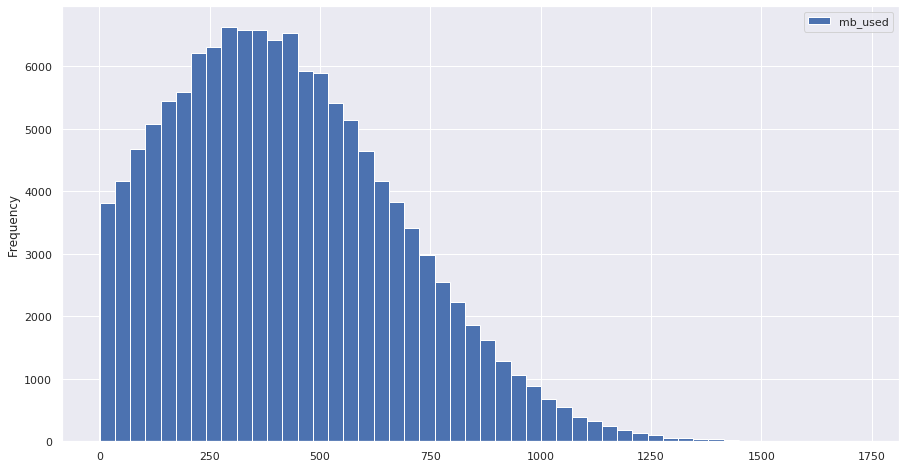

In [10]:
# Возьмём только ненулевые звонки
df_internet = df_internet.query('mb_used != 0')

# округлим значения "вверх" и посмотрим гистограмму
df_internet['mb_used'] = df_internet['mb_used'].apply(np.ceil).astype('int')
hist_plot(df_internet, 'mb_used')

Данные выглядят нормально. Средние сессии - от 100 до 500 мб. 

In [11]:
# приведём столбец session_date к формату времени.
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d', errors='coerce')

In [12]:
df_internet.head(5)

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


#### Данные о сообщениях

Таблица df_messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение


In [13]:
df_messages.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [14]:
# приведём столбец session_date к формату времени.
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d', errors='coerce')

Остальные данные выглядят валидно.

#### Данные о тарифах

Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


In [15]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Данные в таблице выглядят валидно.

#### Данные о пользователях

Таблица df_users (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана


In [16]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Имеем данные по 500 пользователям. Всего 40 из них меняли тарифы (столбец churn_date).
Для удобства, мы заменим 
Остальные столбцы пропущенных значений не имеют.

Столбец дата регистрации имеет не правильный формат.

In [17]:
# приведём столбцы session_date и churn_date к формату времени.
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d', errors='coerce')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d', errors='ignore')

### Вывод
Входные данные представляют собой 5 csv-файлов с таблицами.
Таблицы были проанализированы, обнаружены неверные форматы данных, а также нулевые значения для некоторых столбцов.

По результатам предобработки, данные были приведены к валидным форматам. Нулевые значения, где это применимо, были отброшены, т.к. не влияют на цели нашего исследования.

## 2. Подготовка данных

Необходимо посчитать для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).


Т.к. у нас все рассчёты планируются помесячно, мы добавим в таблицы по использованным услугами столбец с номером месяца, вычисленным из даты:

In [18]:
df_calls['month'] = df_calls['call_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month

In [19]:
# создадим датафрейм, в который будем считать и записывать наши группировки
# сразу добавим туда данные о кол-ве звонков и израсходованных минутах по месяцам
df_used_monthly = df_calls.pivot_table(index = ('user_id','month'), values = 'duration', aggfunc=('count','sum'))
df_used_monthly.head(10)

count  sum
user_id month            
1000    5         17  159
        6         28  172
        7         41  340
        8         42  408
        9         46  466
        10        44  350
        11        37  338
        12        38  333
1001    11        45  430
        12        47  414

In [20]:
# добавим данные по сообщениям
df_pivot = df_messages.pivot_table(index = ('user_id','month'), values = 'id', aggfunc=('count'))
df_used_monthly = df_used_monthly.merge(df_pivot, on=('user_id','month'), how='left')

In [21]:
# добавим данные по использованию интернета
df_pivot = df_internet.pivot_table(index = ('user_id','month'), values = 'mb_used', aggfunc=('sum'))
df_used_monthly = df_used_monthly.merge(df_pivot, on=('user_id','month'), how='left')

In [22]:
# т.к. мы делали merge "налево", то отсутствующие в присоединяемых таблицах данные должны образовать NA у нас
# проверим такие значения, и заменим их на 0 - это значит, что услугами данного типа в этом месяце пользователь не пользовался
df_used_monthly=df_used_monthly.fillna(0)

# также переименуем столбцы
df_used_monthly = df_used_monthly.rename({'count': 'calls_count', 'sum': 'minutes', 'id':'messages', 'sum_y':'mb_total'}, axis=1)

In [23]:
df_used_monthly.reset_index(inplace=True, drop=False)
df_used_monthly.head(10)

,user_id,month,calls_count,minutes,messages,mb_used
0,1000,5,17,159,22.0,2256.0
1,1000,6,28,172,60.0,23257.0
2,1000,7,41,340,75.0,14016.0
3,1000,8,42,408,81.0,14070.0
4,1000,9,46,466,57.0,14581.0
5,1000,10,44,350,73.0,14717.0
6,1000,11,37,338,58.0,14768.0
7,1000,12,38,333,70.0,9827.0
8,1001,11,45,430,0.0,18452.0
9,1001,12,47,414,0.0,14053.0


Хорошо. Теперь посчитаем помесячную выручку с каждого пользователя.

In [24]:
# создадим функцию для прохода по строкам таблицы
def count_money(row):
    # собираем данные по пользованию услугами за месяц
    user = row['user_id']
    tariff = df_users.query('user_id == @user')['tariff'].item()
    tariff_params = df_tariffs.query('tariff_name == @tariff')
    minutes = row['minutes']
    messages = row['messages']
    mb_used = row['mb_used']
    
    # считаем перерасход за звонки, округляем в большую сторону
    calls_mon = np.ceil((minutes - tariff_params['minutes_included'].item()))
    # если пакет не был израсходован
    if calls_mon < 0:
        calls_mon = 0
    # считаем сумму за перерасход
    else:
        calls_mon *= tariff_params['rub_per_minute'].item()
        
    # перерасход за сообщения
    messages_mon = np.ceil((messages - tariff_params['messages_included'].item()))
    if messages_mon < 0:
        messages_mon = 0
    else:
        messages_mon *= tariff_params['rub_per_message'].item()
    
    # перерасход за интернет. МБ переведём сразу в Гб и округлим в большую сторону
    inet_mon = np.ceil(((mb_used - tariff_params['mb_per_month_included'].item()) / 1024))
    if inet_mon < 0:
        inet_mon = 0
    else:
        inet_mon *= tariff_params['rub_per_gb'].item()
    
    # считаем общий счёт за месяц
    monthly_bill = calls_mon + messages_mon + inet_mon + tariff_params['rub_monthly_fee'].item()
    return monthly_bill

In [25]:
# применим функцию и запишем её результат в отдельный столбец
# Я не нашёл способа работать с одним значением в Series, кроме метода .item()...
# Но он выдаёт ошибки ниже, хотя и работает

df_used_monthly['bill'] = df_used_monthly.apply(count_money, axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: `item` has been deprecated and will be removed in a future version
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: `item` has been deprecated and will be removed in a future version
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: `item` has been deprecated and will be removed in a future version
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: `item` has been deprecated and will be removed in a future version
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: `item` has been deprecated and will be removed in a future version
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: `item` ha

In [26]:
df_used_monthly.head(10)

,user_id,month,calls_count,minutes,messages,mb_used,bill
0,1000,5,17,159,22.0,2256.0,1950.0
1,1000,6,28,172,60.0,23257.0,1950.0
2,1000,7,41,340,75.0,14016.0,1950.0
3,1000,8,42,408,81.0,14070.0,1950.0
4,1000,9,46,466,57.0,14581.0,1950.0
5,1000,10,44,350,73.0,14717.0,1950.0
6,1000,11,37,338,58.0,14768.0,1950.0
7,1000,12,38,333,70.0,9827.0,1950.0
8,1001,11,45,430,0.0,18452.0,1350.0
9,1001,12,47,414,0.0,14053.0,550.0


### Вывод
В соответсвии с целями исследования, была проведена обработка данных. В результате сформирована таблица со средними показателями пользованиям услугами для каждого пользователя, разбитые по месяцам.
Эти данные будут использоваться для дальнейшего анализа.

## 3. Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [27]:
# создадим массивы с ID пользователей разных тарифов
smart_users = df_users.query('tariff == "smart"')['user_id'].unique()
ultra_users = df_users.query('tariff == "ultra"')['user_id'].unique()

In [28]:
# разобьём таблицу с данными по месяцам на две, исходя из спользованных тарифов
smart_monthly = df_used_monthly.query('user_id in @smart_users')
ultra_monthly = df_used_monthly.query('user_id in @ultra_users')

In [29]:
# и сгруппируем даныне по пользователям, чтобы посмотреть среднее использование сервисов по пользователям
smart_users_mean = smart_monthly.pivot_table(index='user_id', values = ('minutes', 'messages', 'mb_used', 'bill'), aggfunc='mean').reset_index()
ultra_users_mean = ultra_monthly.pivot_table(index='user_id', values = ('minutes', 'messages', 'mb_used', 'bill'), aggfunc='mean').reset_index()

У нас получились два датафрейма со средним использованием услуг оператора по каждому пользователю.

Изучим поведение пользователей.
Для начала, посмотрим на распределение среднего счёта по пользователям разных тарифов.

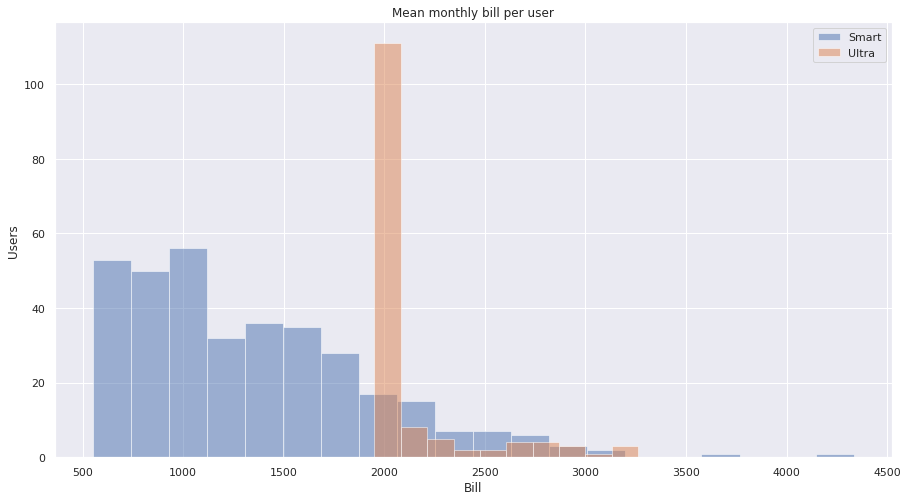

In [30]:
#построим графики по среднему счёту
ax = smart_users_mean['bill'].hist(bins=20, figsize=(15,8), label='Smart', alpha=0.5)
ultra_users_mean['bill'].hist(ax=ax, bins=10, label='Ultra', alpha=0.5)

ax.set_xlabel('Bill')
ax.set_ylabel('Users')
ax.set_title('Mean monthly bill per user')
plt.legend()

Можно сделать вывод, что пользователям тарифа Smart часто не хватает включённых в абонентскую плату пакетов. Видно, что большинство пользователей Smart активируют услуги "сверх" и месячный счёт для многих выше абонентской платы. Хотя есть и те, кому хватает.

А вот среди пользователей тарифа Ultra, наоборот - подавляющему большинству хватает включённых в тариф услуг. Хотя также есть пользователи, кто услуги докупает.

Теперь посмотрим, а какие вообще потребности у пользователей разных тарифов.
Посчитаем среднее и дисперсию для разных использованных услуг. Так как у нас весьма ограниченный набор данных, все характеристики будут являться статистиками для генеральной совокупности всех пользователей каждого тарифа.

In [31]:
# рассчёты сохраним в отдельный фрейм
tariffs_stats = pd.DataFrame()
tariffs_stats['tariff'] = ['Smart', 'Ultra']

# считаем разом для всех значений
for elems in ['minutes', 'messages', 'mb_used', 'bill']:
    # среднее значение
    tariffs_stats['{}_mean'.format(elems)] = [smart_users_mean[elems].mean(), ultra_users_mean[elems].mean()]
    # дисперсия по выборке
    tariffs_stats['{}_var'.format(elems)] = [np.var(smart_users_mean[elems], ddof=1), np.var(ultra_users_mean[elems], ddof=1)]
    # стандартное отклонение
    tariffs_stats['{}_std'.format(elems)] = tariffs_stats['{}_var'.format(elems)] ** 0.5
    # округлим
    tariffs_stats = tariffs_stats.round(1)

In [40]:
tariffs_stats

,tariff,minutes_mean,minutes_var,minutes_std,messages_mean,messages_var,messages_std,mb_used_mean,mb_used_var,mb_used_std,bill_mean,bill_var,bill_std
0,Smart,420.8,20578.3,143.5,32.4,704.9,26.6,16205.8,12926754.9,3595.4,1331.3,369738.5,608.1
1,Ultra,547.0,71872.1,268.1,54.0,2076.6,45.6,19556.8,70324666.7,8386.0,2087.0,92339.8,303.9


Для наглядности, сразу построим и графики распределения.

In [33]:
# функция для построения графиков распределения
def plot_users_needs(nbins=50):
    for cols in ['minutes', 'messages', 'mb_used']:
        sns.set(style = 'darkgrid')
        plt.figure(figsize=(17,8))
        ax= sns.distplot(ultra_users_mean[cols], bins=nbins, label='Ultra')
        sns.distplot(smart_users_mean[cols], bins=nbins, label='Smart', ax=ax)
        ax.set_title('Monthly {} usage distribution'.format(cols))
        plt.legend()
        plt.show()

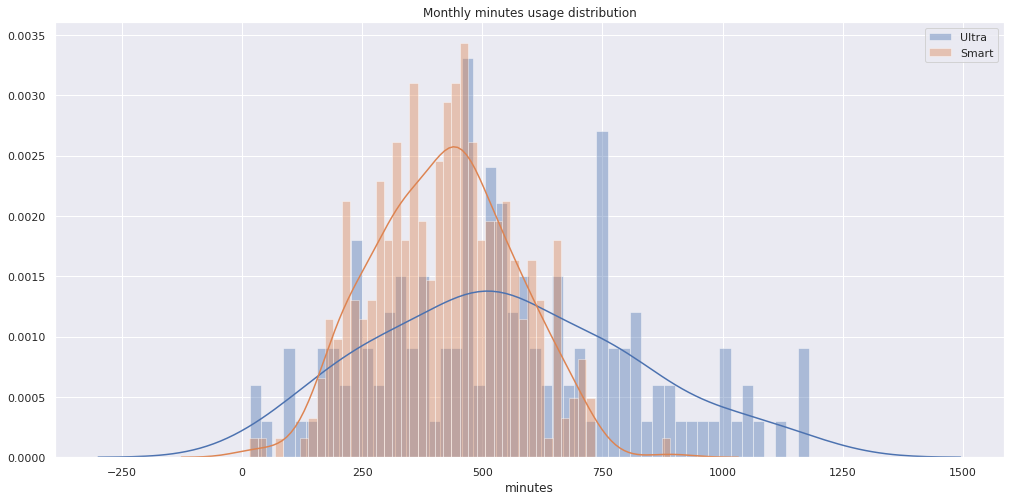

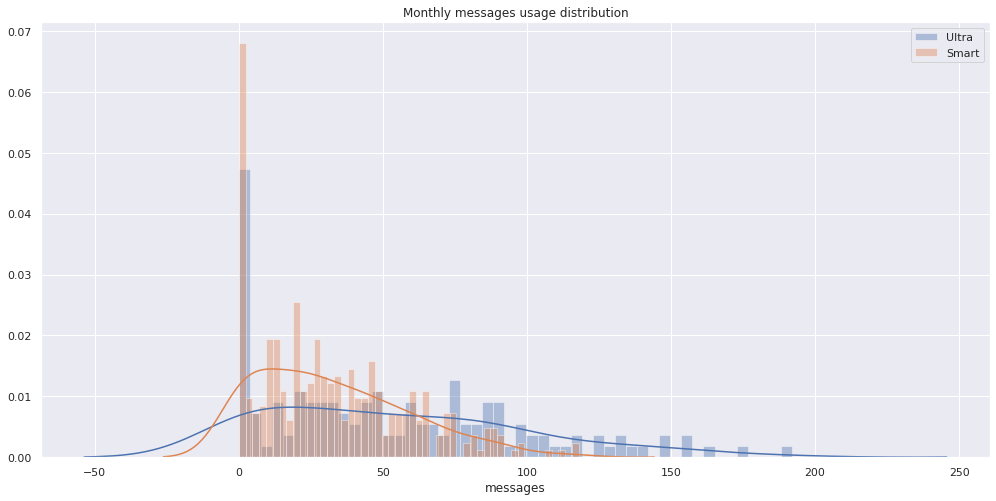

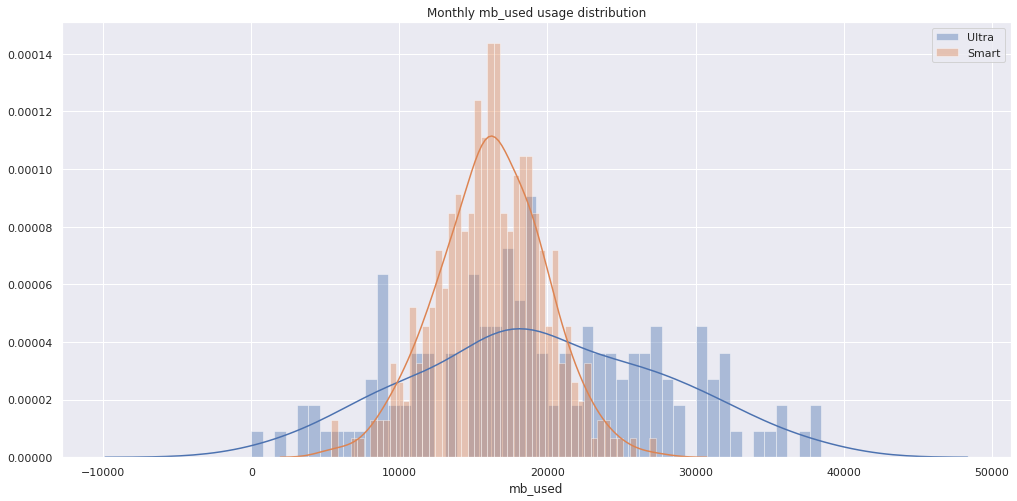

In [34]:
plot_users_needs()

### Выводы:
1. Распределения использованных минут является нормальным распределением. Средние значения для обоих тарифов не сильно отличаются (420 и 540). А вот стандартное отклонение для пользователей Ultra почти в 2 раза больше, чем у пользователей Smart. Это очевидно и на графике - распределение Ultra более "плоское" - значения более разбросаны.
    Однако интересно, что включённые 3000 минут в Ultra никто их нашей выборки не выговаривает. И по правилу "3Хсигма", врятли кто-то из пользователей этого тарифа в принципе использует все 3000 минут.

2. Распределения отправленных сообщений являются скошенными влево. Это связано с тем, что многие пользователи вовсе не пользователись сообщениями (0 сообщений или около того за месяц). В среднем, на Ultra сообщений отправляют больше, однако для данного тарифа пропорционально больше и стандартное отклонение. 

3. Пользователи обоих тарифов используют интернет примерно одинаково - в среднем 16 и 19 Гб в месяц. Однако, учитывая отклонения, пользователи Smart видимо являются более активными пользователями интернет, т.к. 99% из них потребляют от 6 ГБ (std=3.5). Средняя величина чуть больше лимиту по тарифу (15 Гб), что подтверждает теорию о том, что пользователям Smart как правило не хватает включённого в тариф трафика.
    А вот пользователи Ultra, хоть и имеют средний трафик немного выше, но и отклонение отличается от Smart почти в 3 раза. При этом пользователи Ultra в большинстве не превышают тарифные 30Гб в месяц, хотя есть и те, кто докупал пакеты. 
    
4. Несмотря на абонентскую плату всего 550р., средний счёт по тарифу Smart равен 1331 р., т.е. более чем в 2 раза выше! Пользователям явно не хватает включённых в тариф услуг.
    А вот для Ultra, средний счёт (2087 р.) не сильно отличается от абонентской платы - т.е. пользователям Ultra как правило хватает включённых услуг.

## 4. Проверка гипотез

Необходимо проверить гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Сформулируем двусторонние гипотезы.

Ho: "Средняя выручка Ультра равна средняя выручка Смарт."

H1: "Средние выручки по тарифам не равны"

In [35]:
# задаём значимость в 10%
alpha = 0.05

# t-test для данных по двум тарифам, с учётом разных дисперсий
results = st.ttest_ind(
    ultra_monthly['bill'],
    smart_monthly['bill'],
    equal_var=False
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.727266062008599e-241
Отвергаем нулевую гипотезу


Получается, что нулевая гипотеза крайне маловероятна. А значит скорее всего, альтернативная гипотеза об отличии выручки по тарифам верна.

### 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Ho: "Средняя выручка пользователей из Москвы равна средней выручке других пользователей"


H1: "Средняя выручка пользователей из Москвы больше средней выручки по другим регионам"

Альтернативная гипотеза сформулирована исходя из предположения, что в столице люди тратят больше денег на всё, в том числе связь.

In [36]:
# для проверки гипотезы, нам необходимо подготовить данные по счетам пользователей из Москвы и других регионов раздельно
# сформируем массив с ID москвичей
moscow_users = df_users.query('city == "Москва"')['user_id']

# возьмём массивы с помесячными счетами москвичей и остальных
moscow_bills = df_used_monthly.query('user_id in @moscow_users')['bill']
other_bills = df_used_monthly.query('user_id not in @moscow_users')['bill']

alpha = 0.05
results = st.ttest_ind(
    moscow_bills,
    other_bills,
    equal_var=False
)

print('p-значение:', results.pvalue)

# тест односторонний, вправо
if (results.pvalue/2 < alpha) and (moscow_bills.mean() > other_bills.mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4252867781930174
Не получилось отвергнуть нулевую гипотезу


Гипотезу Ho отвергнуть не получилось. Похоже, что с большой вероятностью, пользователи в Москве тратят примерно столько же на связь, что и в других регионах.

### Вывод:
1. Гипотеза о равенстве средней выручки с пользователей двух тарифов не подтвердилась. 
2. Гипотезу о равенстве средней выручки пользователей Москвы и других регионов отвергнуть не получилось.

## 5. Общий вывод

В ходе работы были изучены данные о пользовании услугами связи по двум тарифам - Smart и Ultra. Предоставленные данные содержали информацию о 500 пользователях этих тарифов.

Данные были предварительно проанализированы и обработаны. Приведены объяснения возможных аномалий, значения отформатированы.

В соответствии с целями исследования, были проведены рассчёты:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя
По результатам была сформирована отдельная таблица с данными рассчётов.

Далее было изучено поведение пользователей разных тарифов - сколько в месяц потребляют услуг каждые из них. Были рассчитаны средние значения разных сервисов, дисперсия и стандартное отклонение. Также были построены графики распределения по использованным значения и проанализированы.
Можно сделать вывод, что пользователям тарифа Smart часто не хватает включённых в абонентскую плату пакетов. Видно, что большинство пользователей Smart активируют услуги "сверх" и месячный счёт для многих выше абонентской платы.
А вот пользователи Ultra редко "вычерпывают" свои лимиты - большинство укладывается во включенные в абон.плату сервисы.

Также можно отметить, что стандартное отклонение использования услуг для тарифа Ultra значительно больше, чем для тарифа Smart. Это может свидетельствовать о том, что поведение пользователей тарифа Ultra различно - вероятно этот тариф используют те, кому необходимы большие лимиты по какой-то из услуг (например, интернет), а другие сервисы используются меньше.
А вот поведение пользователей Smart более стандартно - дисперсия существенно меньше.

Далее в работе были проверены две гипотезы. Для каждой были сформулированы нулевая и альтернативные гипотезы, проведён t-тест. 
Статистическая значимость для обоих тестов была выбрана в 5%. 
1. Гипотеза 1: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается." Гипотеза не отвергнута, выручки пользователей тарифов различаются с высокой вероятностью.
2. Гипотеза 2: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов". Гипотеза не подтвердилась. Выручка пользователей Москвы вероятно не сильно отличается от выручки пользователей других регионов.

Выбрать "лучший" тариф из этих двух не представляется возможным. В тарифе "Smart" слишком мало включённых сервисов - большинству пользователей приходится докупать доп. пакеты. А в тарифе Ultra наоборот, лимиты избыточны - мало кто из пользователей их "вычерпывает".

Оптимальным вариантом видится введение нового тарифа, среднего между имеющимися.